In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#import cvxpy as cp

# d = 40
# k = 5
# u = np.random.randn(d,k)
# v = np.random.randn(d,k)
# A = u @ v.T
#u = u / la.norm(u)

print(torch.cuda.is_available())
torch.set_default_device('cuda:0')

True


- 200/np.sqrt(t) best regularization weight for standard Fro norm error
- previously had best results setting x = V_hat[exp_idx,:], but seems unstable now

In [2]:
def compute_transfer_matrix(Ahat):
    k = 5
    avg_connect_ark = np.zeros((d,d))
    rollout_len = 1000
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

Ast = np.load('AR5_estimate.npy')
num_neurons = 663
d = num_neurons
Ast_new = np.zeros((num_neurons,10*num_neurons+1))
for i in range(10):
    Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ast[0:num_neurons,i*d:i*d+num_neurons]
Ast_new[:,-1] = Ast[0:num_neurons,-1]
#A = compute_transfer_matrix(Ast_new)

FileNotFoundError: [Errno 2] No such file or directory: 'AR5_estimate.npy'

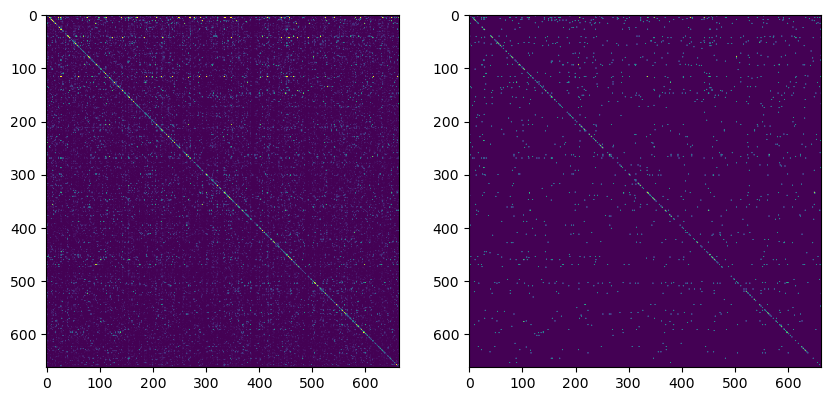

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A, norm=colors.Normalize(vmin=0.0, vmax=.1))

connection_threshold = 1*np.mean(np.diag(A))
A_threshold = (A>threshold).astype(float)
plt.subplot(1,2,2)
plt.imshow(A>threshold, norm=colors.Normalize(vmin=0,vmax=0.5))

# Learn full dynamics

663
[1.0125057  0.70141035 0.6690519  0.63170654 0.61428404 0.60884494
 0.60083544 0.59458584 0.5897332  0.5864161  0.5765337  0.5677414
 0.5598862  0.5571316  0.55597275 0.5544848  0.5508645  0.5459035
 0.54144335 0.53245544 0.53113955 0.52436703 0.52103883 0.51756006
 0.5163394  0.5109591  0.51037395 0.5037701  0.5006315  0.4979246
 0.494338   0.49117324 0.48512882 0.4764666  0.46839917 0.45775753
 0.44861597 0.4343263  0.41967753 0.4136016  0.40205538 0.39715397
 0.39265457 0.38722882 0.3844063  0.3815536  0.3760205  0.3739643
 0.3722812  0.37161115]
663
[0.534415   0.5055565  0.49472755 0.48064682 0.46900192 0.45990136
 0.454528   0.44770327 0.44738293 0.43370143 0.43254355 0.42985192
 0.423345   0.41984236 0.41771257 0.4100779  0.40249175 0.39940178
 0.39796382 0.3933507  0.3878477  0.38500082 0.37932983 0.37695718
 0.37295675 0.37034243 0.3658563  0.36291522 0.3546569  0.34661886
 0.3439685  0.3393296  0.33576313 0.33369124 0.32030004 0.23630717
 0.22895089 0.2200186  0.21407187 

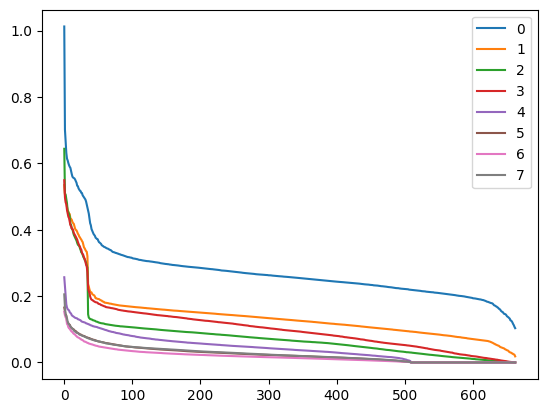

In [474]:
#Ast = np.load('AR5_estimate.npy')
Ast = np.load('./estimated_parameters/Ahat_low_rank_35.npy')
num_neurons = 663
d = 663
for i in range(8):
    Ai = Ast[0:num_neurons,i*d:i*d+num_neurons]
    Ai = Ai# - np.diag(np.diag(Ai))
    _,S,_ = la.svd(Ai)
    plt.plot(S,label=str(i))
    #print(la.matrix_rank(Ai))
    #print(S[0:50])
plt.legend()

In [5]:
class Dynamics:
    def __init__(self,Ast,k,batch_size=1,record_history=True):
        self.Ast = Ast
        self.k = k
        self.d = Ast.shape[0]
        self.record_history = record_history
        self.noise_std = 0.001
        self.batch_size = batch_size
        
        self.shift = np.zeros((self.k*self.d,self.k*self.d))
        for i in range(self.k-1):
            self.shift[i*self.d:(i+1)*self.d,self.d+i*self.d:self.d+(i+1)*self.d] = np.eye(self.d)
        self.A_lifted = np.zeros((k*self.d,k*self.d))
        self.A_lifted[(self.k-1)*self.d:,:] = Ast[:,0:self.d*self.k]
        self.A_lifted += self.shift
        self.B_lifted = np.zeros((k*self.d,k*self.d))
        self.B_lifted[(self.k-1)*self.d:,:] = Ast[:,self.d*self.k:2*self.d*self.k]
        self.v = np.zeros((k*self.d))
        self.v[(self.k-1)*self.d:] = Ast[:,-1]
        
        if batch_size > 1:
            self.state = np.zeros((k*self.d,batch_size))
            self.input = np.zeros((k*self.d,batch_size))
        else:
            self.state = np.zeros(k*self.d)
            self.input = np.zeros(k*self.d)
        self.history = []
        
    def step(self,u,noiseless=False):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:] = u
        if self.record_history:
            self.history.append(np.concatenate((self.state,next_input,[1])))
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + self.v
        if not noiseless:
            noise = np.zeros(self.k*self.d)
            noise[(self.k-1)*self.d:self.k*self.d] = self.noise_std * np.random.randn(self.d)
            next_state += noise
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:], next_state
    
    def step_batch(self,u):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:,:] = u
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + np.outer(self.v,np.ones(self.batch_size))
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:,:], next_state
    
    def estimate(self):
        hist = np.array(self.history)
        xp = hist[1:,(self.k-1)*self.d:self.k*self.d]
        x = hist[:-1,:]
        e, _ = np.linalg.eig(x.T @ x)
        #print(np.max(e),np.min(e))
        Ahat = np.linalg.pinv(x.T @ x + 0.01 * np.eye(x.shape[1])) @ x.T @ xp
        return Ahat.T
    
    def get_state(self):
        return self.state.copy()
    
    def set_state(self, state):
        if self.batch_size > 1 and len(state.shape) == 1:
            self.state = np.outer(state,np.ones(self.batch_size))
        else:
            self.state = state
            
    def get_states(self):
        hist = np.array(self.history)
        return hist[:,(self.k-1)*self.d:self.k*self.d], hist[:,(2*self.k-1)*self.d:2*self.k*self.d]

In [347]:
env = Dynamics(Ast, 5, record_history=False)
u0 = np.zeros(663)
states = []
for t in range(2000):
    s, _ = env.step(u0,noiseless=True)
    states.append(s)
# residual = []
# for t in range(2000):
#     residual.append(la.norm(states[-1] - states[t]))
# plt.plot(residual)
steady_state = states[-1]

NameError: name 'Dynamics' is not defined

In [ ]:
env = Dynamics(Ast, 5, record_history=False)
env2 = Dynamics(Ast, 5, record_history=False)
k = 5
s0 = np.zeros(d*k)
for i in range(k):
    s0[i*d:(i+1)*d] = steady_state
s0 = np.array(s0)
env.set_state(s0)
u0 = np.zeros(663)
u = np.zeros(663)
u = np.random.randn(663)/50
total = np.zeros(663)
for t in range(15):
    if t < 3:
        x, _ = env.step(u, noiseless=True)
    else:
        x, _ = env.step(u0, noiseless=True)
    total += x
pred = transfer_gt @ u + 15*steady_state 
print(la.norm(total - pred))

In [ ]:
def get_obs3(u):
    noise_std = 0.1 / np.sqrt(15)
    k = 5
    s0 = np.zeros(d*k)
    for i in range(k):
        s0[i*d:(i+1)*d] = steady_state.copy()
    env.set_state(s0)
    u0 = np.zeros(663)
    total = np.zeros(663)
    states_all = []
    inputs_all = []
    for i in range(k):
        states_all.append(steady_state.copy())
        inputs_all.append(u0.copy())
    for t in range(15):
        if t < 3:
            x, _ = env.step(u, noiseless=True)
            inputs_all.append(u.copy())
        else:
            x, _ = env.step(u0, noiseless=True)
            inputs_all.append(u0.copy())
        x += noise_std * np.random.randn(663)
        total += x
        states_all.append(x)
    return total - 15*steady_state.copy(), np.array(states_all), np.array(inputs_all)

# Run estimation (one step dynamics)

In [3]:
def compute_transfer_matrix2(Ahat,rollout_len,k=5):
    avg_connect_ark = np.zeros((d,d))
    #rollout_len = 15
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t] 
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

Ast = np.load('./estimated_parameters/AR5_estimate.npy')
print(Ast.shape)
num_neurons = 663
d = num_neurons
k = 5
Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
for i in range(2*k):
    Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ast[0:num_neurons,i*d:i*d+num_neurons]
Ast_new[:,-1] = Ast[0:num_neurons,-1]

def compute_transfer_gt(Ast_new):
    transfer_gt = compute_transfer_matrix2(Ast_new, rollout_len=15, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=14, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=13, k=k)
    return transfer_gt

transfer_gt = compute_transfer_gt(Ast_new)
_,S,_ = la.svd(transfer_gt)
print(S.sum())

(663, 6631)
208.43552629231252


0.9457559201460944


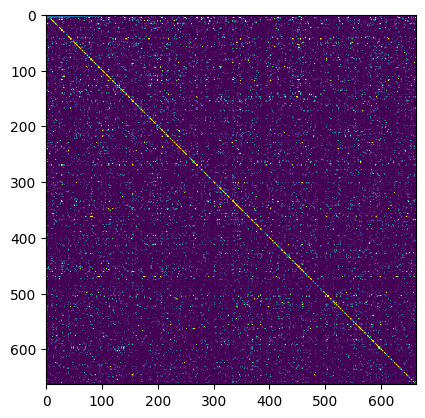

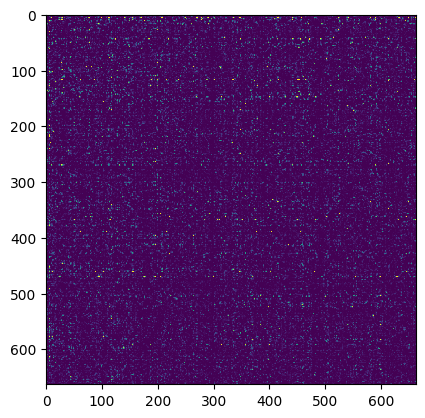

In [223]:
_,S,_ = la.svd(transfer_gt)
plt.plot(S)

print(la.norm(transfer_gt - transfer_gt.T, 'fro') / la.norm(transfer_gt, 'fro'))
plt.imshow(transfer_gt, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.show()

plt.imshow(transfer_gt-transfer_gt.T, norm=colors.Normalize(vmin=0.0, vmax=.1))
plt.show()

### load low-rank matrices

In [4]:
#params = np.load('./estimated_parameters/Ahat_D_U_V_low_rank_[photostim_0404_date_070623_r15].npz.npy', allow_pickle=True)[()]
params = np.load('./estimated_parameters/Ahat_D_U_V_low_rank_[photostim_59_r15].npz.npy', allow_pickle=True)[()]
print(params['W_v'][1].shape)

num_neurons = 502 #633
d = num_neurons
k = 4
Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
for i in range(2*k):
    if i < k:
        Ast_new[:,i*num_neurons:(i+1)*num_neurons] = np.diag(params['alpha'][i]) + params['W_u'][i] @ params['W_v'][i].T
    else:
        Ast_new[:,i*num_neurons:(i+1)*num_neurons] = np.diag(params['beta'][i-k]) + params['B_u'][i-k] @ params['B_v'][i-k].T
transfer_gt = compute_transfer_gt(Ast_new)
print(la.norm(transfer_gt, 'fro'))

(502, 15)
12.086725176665665


0 0.0
1 0.047328414481650614
2 0.09295934898403817
3 0.1355481914141246
4 0.1756184434614751
5 0.211420694894458
6 0.24397622956375714
7 0.2758999713736484
8 0.30700067233952605
9 0.3370322958018473
10 0.3654074759298744
11 0.3930268469930483
12 0.42003451006348513
13 0.4457109493640134
14 0.4712964554741356
15 0.49597053861838664
16 0.5192677482857175
17 0.5415317289046417
18 0.5636037038740161
19 0.5851989132405299
20 0.6058065347105496
21 0.6259666614402113
22 0.6454123646683623
23 0.6639547032845198
24 0.6822304225826431
25 0.6998612062739964
26 0.7167686201604915
27 0.7333151376028234
28 0.7490562793782841
29 0.764345673439155
30 0.7790967195986457
31 0.7931276887294417
32 0.8068133459080851
33 0.8202370726566602
34 0.8332660198943586
35 0.845939778038558
36 0.849928369894756
37 0.853641923861898
38 0.8565908144695543
39 0.859452787639852
40 0.8618858392358006
41 0.8642377287721126
42 0.8664107553874131
43 0.8683618324583416
44 0.8702692820191809
45 0.872133234771851
46 0.87398495

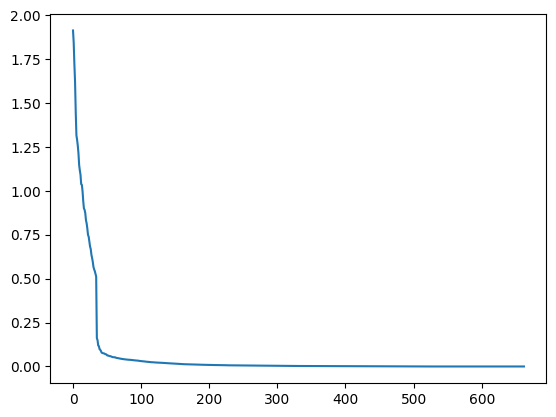

40.43278905860625


In [478]:
U,s,V = la.svd(transfer_gt - np.diag(np.diag(transfer_gt)))
for i in range(75):
     print(i, np.sum(s[0:i]) / np.sum(s))
# # plt.plot(s)
# #print(s[0],np.sum(s))
# s[1:] = 0
# print(la.norm(U @ np.diag(s) @ V - transfer_gt) / la.norm(transfer_gt))
# transfer_gt = U @ np.diag(s) @ V
plt.plot(s)
plt.show()
#print(s[0:100])
print(np.sum(s))

In [87]:
def compute_error(A_gt, A_est, no_diag=False):
    if no_diag:
        A1 = A_gt - np.diag(np.diag(A_gt))
        A2 = A_est - np.diag(np.diag(A_est))
        return np.linalg.norm(A1 - A2, 'fro')
    return np.linalg.norm(A_gt - A_est, 'fro')

def compute_pred_error(A_gt, A_est, max_on=10, no_diag=False):
    d = A_gt.shape[0]
    T = int(100*la.norm(A_gt, 2) + 100*la.norm(A_est, 2))
    mean_error = 0
    for t in range(T):
        u_idx = np.random.choice(range(d), size=max_on, replace=False)
        u = np.zeros(d)
        u[u_idx] = 1.0
        if no_diag:
            delta = (A_gt - A_est) @ u
            delta[u_idx] = 0
            mean_error += la.norm(delta, 2) / T
        else:
            mean_error += la.norm((A_gt - A_est) @ u, 2) / T
    return mean_error

In [238]:
def draw_num2(S,rate=0.5):
    max_S = np.max(S)
    if np.random.rand() > rate:
        while True:
            idx = np.random.randint(0,len(S)-1)
            if S[idx] >= max_S/2:
                return idx
    else:
        return draw_num3(S)
    
def draw_num3(S):
    total_S = np.sum(S)
    rand_num = np.random.rand()
    running_sum = 0
    for i in range(len(S)):
        running_sum += S[i]
        if rand_num <= running_sum / total_S:
            return i
        
def project_input(u, k=13):
    u2 = np.zeros(len(u))
    for i in range(k):
        idx = np.argmax(u)
        u2[idx] = 1.0 #np.min([1.0,u[idx]])
        u[idx] = -100
    #u2_max = np.max(u2)
    #u2 = u2 / u2_max
    return u2

def generate_rand_input(d,max_on):
    idx = np.random.choice(np.linspace(0,d-1,d).astype(int), size=max_on, replace=False)
    u = np.zeros(d)
    u[idx] = 1.0
    return u

def get_obs(A_gt, u, noise_std=0.25):
    d = A_gt.shape[0]
    return A_gt @ u + noise_std*np.random.randn(d)

def get_cov(inputs,start,cov_len):
    d = inputs.shape[0]
    cov = np.zeros((d,d))
    idx = start
    for i in range(cov_len):
        cov += np.outer(inputs[:,idx],inputs[:,idx])
        idx += 1
        if idx >= inputs.shape[1]:
            idx = 0
    return cov
    
def run_experiment(params):
    data = {}
    data["time"] = []
    data["input_norm"] = 0
    for est_type in params["est_type"]:
        data[est_type] = []
        data[est_type + '_pred_error'] = []
    U = []
    Y = []
    d = params["d"]
    A_gt = params["A_gt"]
    A_nuc = None
    A_input = None
    input_cov = np.zeros((d,d))
    _,S_hat,V_hat = la.svd(A_gt)
    
    if params["type"] == "active":
        u_uniform, _ = input_design.design_inputs_constrained(np.random.randn(d,d),
                                                             n_iters=200,
                                                             l1_constraint=params["max_on"],
                                                             k=d,
                                                             num_batches=2000,
                                                             verbose=False,
                                                             V_design=True)
        u_uniform_cov = u_uniform @ u_uniform.T
        input_uniform_idx = 0
    
    if params["type"] == "oracle":
        V_design = (params["design_type"] == "V")
        input_idx = 0
        if params["no_diag"]:
            A_oracle_design = A_gt #transfer_gt_lr
        else:
            A_oracle_design = A_gt
        u_oracle, _ = input_design.design_inputs_constrained(A_oracle_design,
                                                         n_iters=100,
                                                         l1_constraint=params["max_on"],
                                                         k=params["inputs_r"],
                                                         num_batches=np.min([1000,params["T"]]),
                                                         verbose=False,
                                                         V_design=V_design)
        
    for t in range(params["T"]):
        if params["type"] == "passive":
            u = generate_rand_input(d, params["max_on"])
        elif params["type"] == "oracle":
            if params["mix_rand"] and np.mod(t,2) == 0:
                u = generate_rand_input(d, params["max_on"])
            else:
                u = u_oracle[:,input_idx]
                input_idx += 1
                if input_idx >= u_oracle.shape[1]:
                    input_idx = 0
        elif params["type"] == "active":
            #if (params["mix_rand"] and np.mod(t,2) == 0) or t <= params["active_update_interval"]:
            if (params["mix_rand"] and np.mod(t,4) == 0) or t <= params["record_interval"] + 1:
                #u = generate_rand_input(d, params["max_on"])
                u = u_uniform[:,input_uniform_idx]
                input_uniform_idx += 1
                if input_uniform_idx >= u_uniform.shape[1]:
                    input_uniform_idx = 0
            else:
#                 input_idx = draw_num2(S_hat, rate=0.5)
#                 u = V_hat[input_idx,:]
#                 u = project_input(u, k=params["max_on"])
                #input_idx = np.random.randint(0, high=1000)
                u = u_active[:,input_idx]
                input_idx += 1
                if input_idx >= u_active.shape[1]:
                    input_idx = 0
            #if np.mod(t,params["active_update_interval"]) == 0 and t > 0:
            if (np.mod(t, params["record_interval"]) == 1 and t > 10): # or t == 500:
                # A_input = est.estimate_ls(U,Y)
                #_,S_hat,V_hat = la.svd(A_input)
                #if A_input is None:
                #    A_input = est.estimate_ls(U,Y)
                #A_input = est.estimate_gd_nuc_project(U,Y,reg=params["nuc_reg"],lr=0.0001,n_iters=500,transfer0=A_input)
                print(t,'computing input')
                V_design = (params["design_type"] == "V")
                input_idx = 0
                if params["no_diag"]:
#                     A_ls = est.estimate_ls(U,Y)
#                     if t < 1000:
#                         n_iters = 1500
#                     else:
#                         n_iters = 500
#                     A_nuc, D_nuc, UV_nuc = est.estimate_gd_nuc_project_diag(U,Y,reg=150,lr=0.0001,n_iters=n_iters,transfer0=A_ls)
#                     A_input = UV_nuc
                    A_input = A_nuc
                else:
                    #A_ls = est.estimate_ls(U,Y)
                    #A_nuc = est.estimate_gd_nuc_project(U,Y,reg=100,lr=0.0001,n_iters=500,transfer0=A_ls)
                    #A_lr = est.estimate_gd_lowrank_alternate2(U,Y,rank=params["rank_reg"],lr=0.01,n_iters=500,transfer0=A_ls)
                    A_input = A_nuc
#                 _,S_input,_ = la.svd(A_input)
#                 for sig_idx in range(len(S_input)):
#                     if np.sum(S_input[0:sig_idx]) / np.sum(S_input) > 0.9:
#                         inputs_r = sig_idx
#                         print(inputs_r)
#                         break
                #unif_cov = get_cov(u_uniform,input_uniform_idx,250)
#                 if t < 1000:
#                     num_batches = 375
#                 else:
                #V_true = input_design.est_V(U,Y,params["inputs_r"])
                num_batches = 750
                u_active, _ = input_design.design_inputs_constrained(A_input,
                                                                 n_iters=400,
                                                                 l1_constraint=params["max_on"],
                                                                 k=params["inputs_r"],
                                                                 num_batches=num_batches,
                                                                 verbose=False,
                                                                 V_design=V_design,
                                                                 cov0=input_cov / num_batches,
                                                                 V_true=None)
        obs = get_obs(A_gt, u, noise_std=params["noise_std"])
        input_cov += np.outer(u,u)
        U.append(u)
        Y.append(obs)
        data["input_norm"] += np.linalg.norm(u, 1) / params["T"]
        
        if np.mod(t, params["record_interval"]) == 0 and t > 0:
            print("estimating, t = " + str(t))
            data["time"].append(t)
            A_ls = est.estimate_ls(U,Y)
            if "ls" in params["est_type"]:
                data["ls"].append(compute_error(A_gt, A_ls, no_diag=params["no_diag"]))
                data["ls_pred_error"].append(compute_pred_error(A_gt, A_ls, no_diag=params["no_diag"]))
            if "nuc" in params["est_type"]:
                print("estimating nuc")
                if params["no_diag"]:
                    A_nuc, D_nuc, UV_nuc = est.estimate_gd_nuc_project_diag(U,Y,reg=params["nuc_reg"],lr=0.0001,n_iters=500,transfer0=A_ls)
                else:
                    A_nuc = est.estimate_gd_nuc_project(U,Y,reg=params["nuc_reg"],lr=0.0001,n_iters=500,transfer0=A_ls)
                data["nuc"].append(compute_error(A_gt, A_nuc, no_diag=params["no_diag"]))
                data["nuc_pred_error"].append(compute_pred_error(A_gt, A_nuc, no_diag=params["no_diag"]))
            if "nuc-ls" in params["est_type"]:
                if params["no_diag"]:
                    A_nuc_ls = refit_nuc_nodiag(UV_nuc,A_nuc,U,Y)
                else:
                    A_nuc_ls = refit_nuc(A_nuc,U,Y)
                data["nuc-ls"].append(compute_error(A_gt, A_nuc_ls, no_diag=params["no_diag"]))
                data["nuc-ls_pred_error"].append(compute_pred_error(A_gt, A_nuc_ls, no_diag=params["no_diag"]))
            if "lowrank" in params["est_type"]:
                print("estimating lowrank")
                if params["no_diag"]:
                    A_lr = est.estimate_gd_lowrank_alternate2_diag(U,Y,rank=params["rank_reg"],lr=0.01,n_iters=500,transfer0=A_ls)
                    #A_lr = est.estimate_gd_lowrank_project_diag(U,Y,rank=params["rank_reg"],lr=0.25,n_iters=2000,transfer0=A_ls)
                else:
                    A_lr = est.estimate_gd_lowrank_alternate2(U,Y,rank=params["rank_reg"],lr=0.01,n_iters=500,transfer0=A_ls)
                data["lowrank"].append(compute_error(A_gt, A_lr, no_diag=params["no_diag"])) 
                data["lowrank_pred_error"].append(compute_pred_error(A_gt, A_lr, no_diag=params["no_diag"]))
    return data         

In [50]:
def refit_nuc(Anuc,X,Y):
    X = np.array(X)
    Y = np.array(Y)
    U,S,V = la.svd(Anuc)
    Shat = U.T @ la.pinv(V @ X @ X.T @ V.T) @ X @ Y
    return U @ Shat @ V

def refit_nuc_nodiag_old(Anuc,Dnuc,X,Y):
    X = np.array(X).T
    Y = np.array(Y).T
    U,S,V = la.svd(Anuc)
    Shat = U.T @ la.pinv(V @ X @ X.T @ V.T) @ V @ X @ (Y - Dnuc @ X).T
    return Dnuc + U @ Shat @ V

def refit_nuc_nodiag(Anuc,Dnuc,X,Y):
    U,S,V = la.svd(Anuc)
    Xtil = V @ np.array(X).T
    Ytil = U @ (np.array(Y).T - Dnuc @ np.array(X).T)
    for i in range(len(S)):
        Xi = Xtil[i,:]
        Yi = Ytil[i,:]
        S[i] = Xi.T @ Yi / (Xi.T @ Xi)
    return Dnuc + U @ np.diag(S) @ V

estimating, t = 1000
estimating nuc


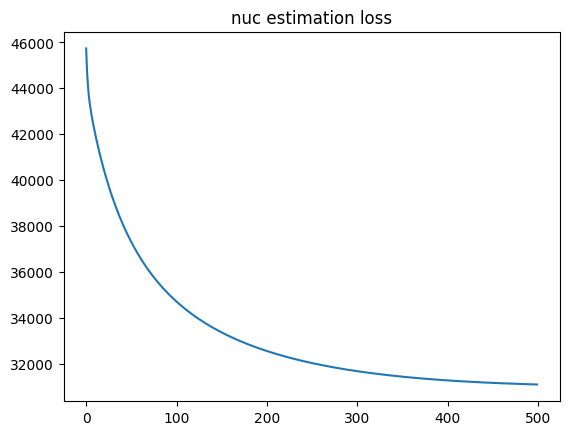

estimating, t = 2000
estimating nuc


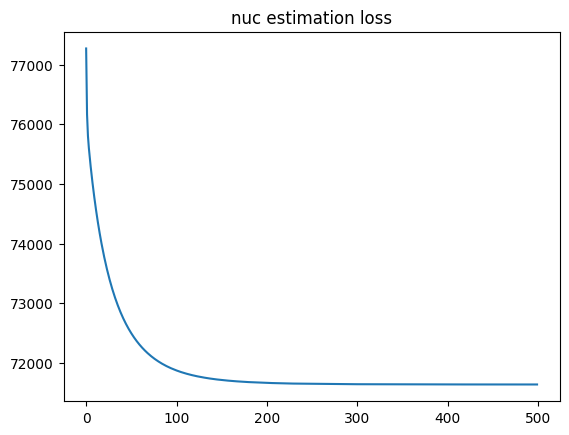

estimating, t = 3000
estimating nuc


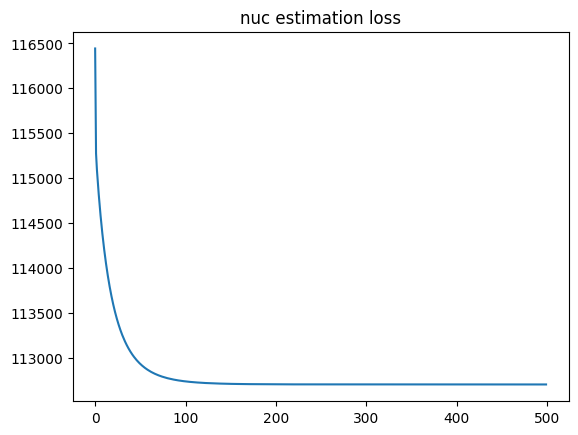

estimating, t = 4000
estimating nuc


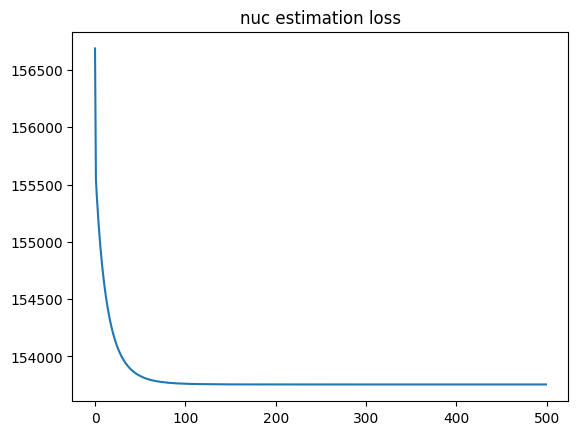

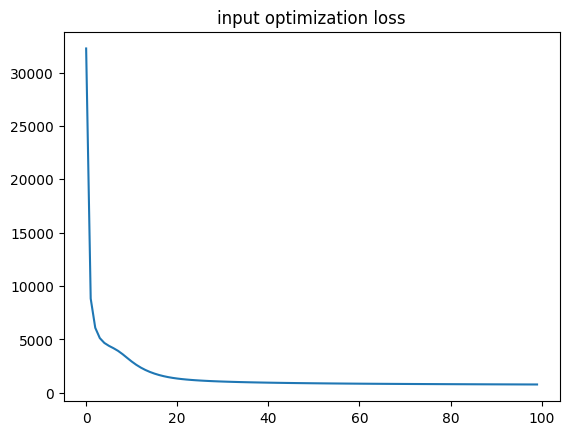

estimating, t = 1000
estimating nuc


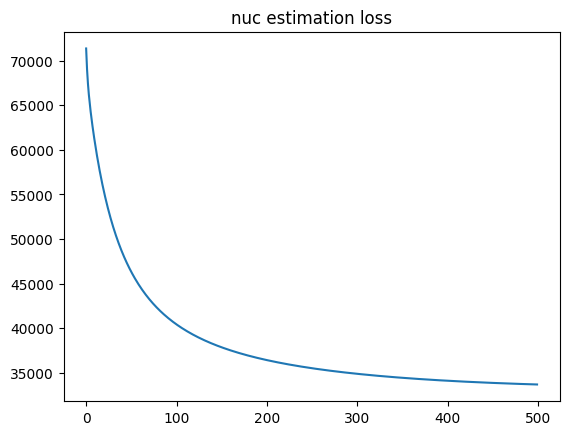

estimating, t = 2000
estimating nuc


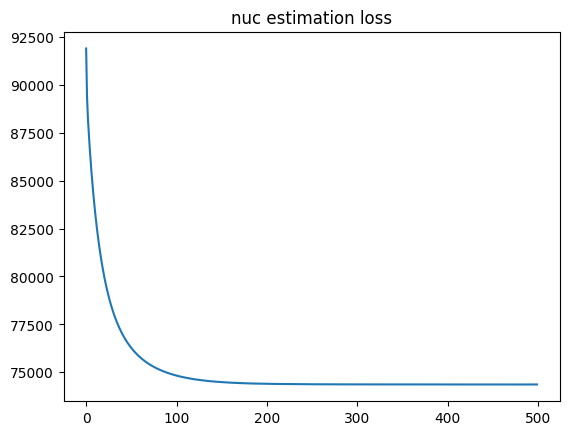

estimating, t = 3000
estimating nuc


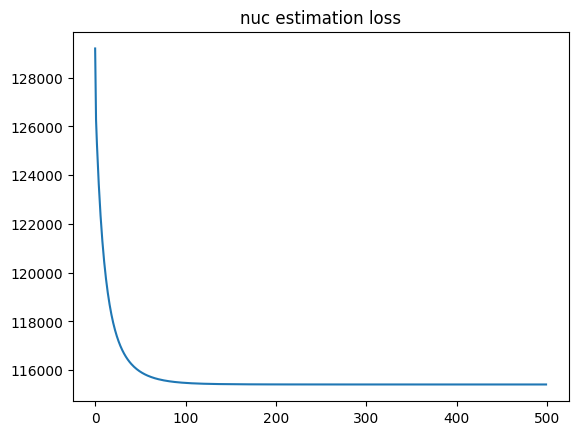

estimating, t = 4000
estimating nuc


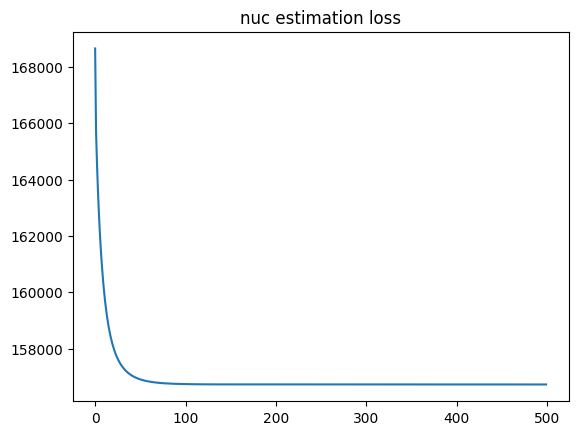

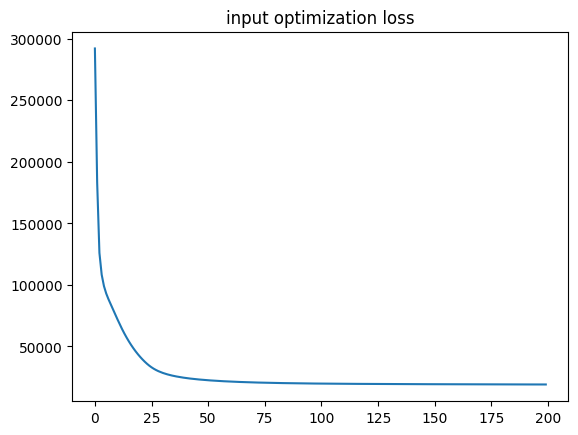

estimating, t = 1000
estimating nuc


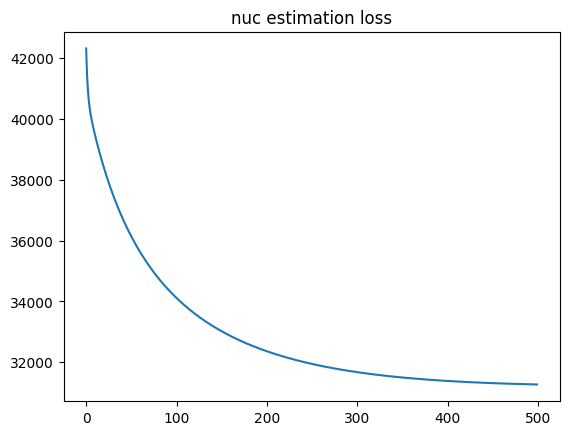

1001 computing input


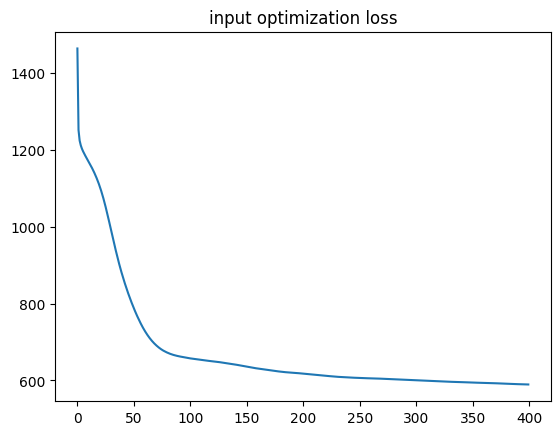

estimating, t = 2000
estimating nuc


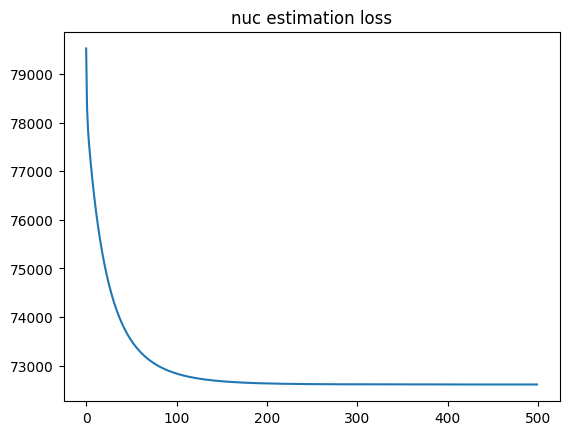

2001 computing input


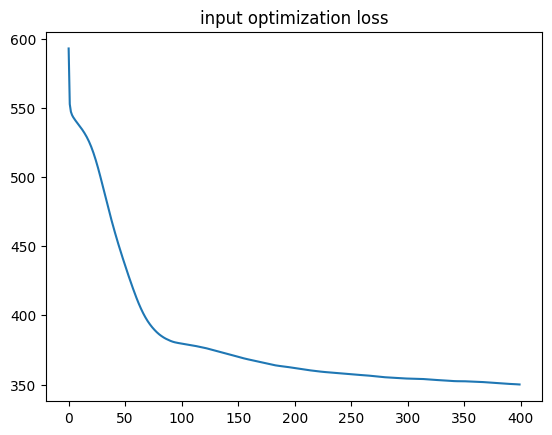

estimating, t = 3000
estimating nuc


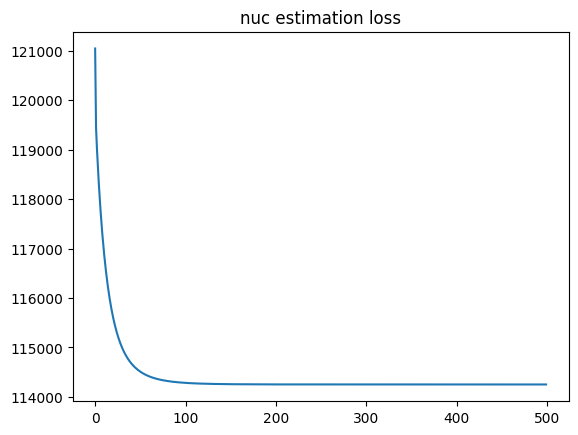

3001 computing input


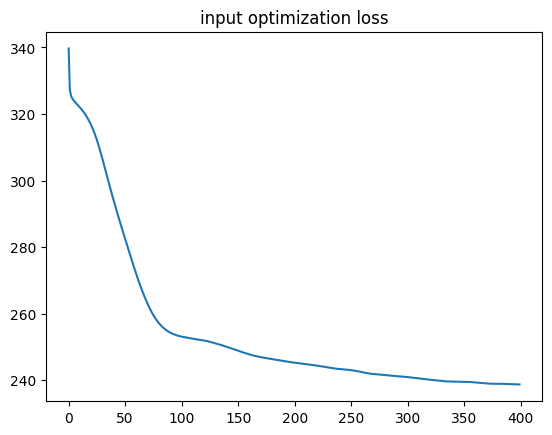

estimating, t = 4000
estimating nuc


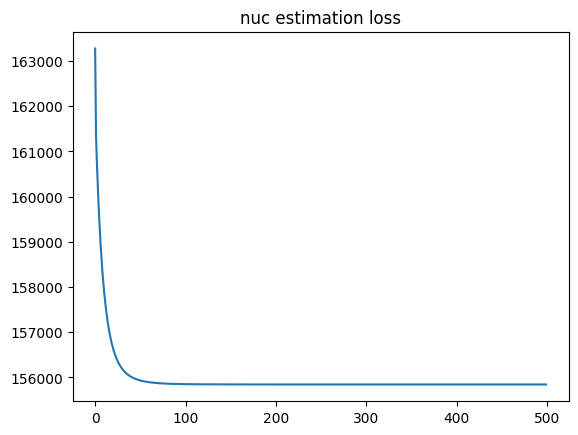

In [239]:
import importlib
import input_design
import estimation_procedures as est
importlib.reload(est)
importlib.reload(input_design)

data = {}
params = {
    "name": "passive",
    "A_gt": transfer_gt,
    "T": 4001,
    "record_interval": 1000,
    "type": "passive",
    "est_type": ["nuc"],
    "d": 663,
    "max_on": 30, 
    "mix_rand": True,
    "no_diag": False,
    "rank_reg": 100,
    "nuc_reg": 210,
    "inputs_r": 100, 
    "design_type": "V",
    "active_update_interval": 20,
    "noise_std": 0.25 
}

data_new = run_experiment(params)
data[params["name"]] = data_new


params["name"] = "oracle"
params["type"] = "oracle"
data_new = run_experiment(params)
data[params["name"]] = data_new


params["name"] = "active"
params["type"] = "active"
data_new = run_experiment(params)
data[params["name"]] = data_new

# Plotting results

passive input norm = 29.999999999999922
oracle input norm = 30.0000000200221
active input norm = 30.000000077228222


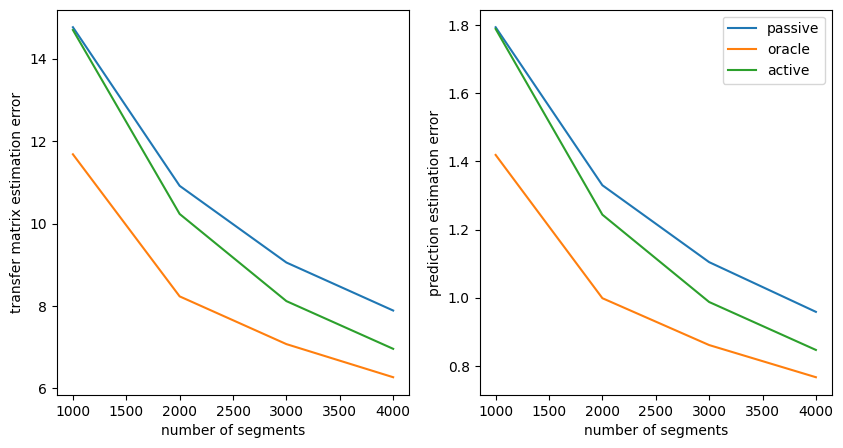

23.020160648180894
{'passive': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999999999922, 'nuc': [14.761524507816905, 10.914562324285432, 9.054980686311255, 7.890879513555485], 'nuc_pred_error': [1.793990178499152, 1.3300688160417788, 1.1043916365517472, 0.9584585553676226]}, 'oracle': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.0000000200221, 'nuc': [11.67989658245524, 8.233802431154515, 7.0763592790066046, 6.273491645406474], 'nuc_pred_error': [1.4191216956255335, 0.9985441559845113, 0.8609876840593976, 0.7665650765934436]}, 'active': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000077228222, 'nuc': [14.694630148377186, 10.232196060508594, 8.119207034602224, 6.962226070140464], 'nuc_pred_error': [1.7889691753071082, 1.2436795766107105, 0.9873698099054862, 0.8466517786087067]}}


In [240]:
# exclude = ['time','input_norm','ls','ls_pred_error','active (V samp)','lowrank', \
#            'active_uniform_nuc2','active_inputr10','active_uniform_nuc150_history']
exclude = ['time','input_norm','ls','ls_pred_error','active (V samp)','lowrank','active_Vest']
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for name in data.keys():
    for est_type in data[name].keys():
        if est_type not in exclude and name not in exclude and "pred_error" not in est_type:
            plt.plot(data[name]["time"], data[name][est_type], label=name + ", " + est_type)
    print(name + " input norm = " + str(data[name]["input_norm"]))
plt.ylabel('transfer matrix estimation error')
plt.xlabel('number of segments')
#plt.legend()

plt.subplot(1,2,2)
for name in data.keys():
    for est_type in data[name].keys():
        if est_type not in exclude and name not in exclude and "pred_error" in est_type:
            if est_type[:-11] not in exclude:
                #plt.plot(data[name]["time"], data[name][est_type], label=name + ", " + est_type)
                plt.plot(data[name]["time"], data[name][est_type], label=name)
plt.ylabel('prediction estimation error')
plt.xlabel('number of segments')
plt.legend()
plt.show()
plt.show()

print(np.linalg.norm(transfer_gt, 'fro'))
print(data)

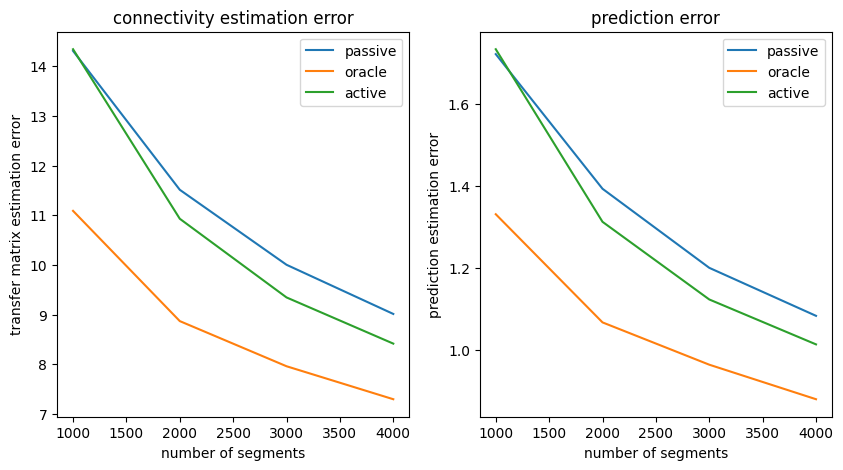

33.36205882041665
{'passive': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999999999922, 'nuc': [14.307857046889724, 11.512059081205441, 10.002344162274468, 9.01272417458994], 'nuc_pred_error': [1.7221975625036776, 1.3937179890187683, 1.200862120037693, 1.0837442391968153]}, 'oracle': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000064833543, 'nuc': [11.087908256345756, 8.868710734060723, 7.959821766034535, 7.296189215297858], 'nuc_pred_error': [1.3316119532926267, 1.0677396553017724, 0.9645540731543448, 0.8803164407858317]}, 'active': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000073891187, 'nuc': [14.341468146627697, 10.928867693171645, 9.344926176522252, 8.415484015805985], 'nuc_pred_error': [1.734170277143392, 1.3130982072864452, 1.123682438064027, 1.0140940459549643]}}


In [175]:
keys = ['passive','oracle','active']
names = {'passive': 'passive', 'oracle': 'oracle', 'active':'active'}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for name in keys:
    plt.plot(data[name]["time"], data[name]['nuc'], label=names[name])
plt.ylabel('transfer matrix estimation error')
plt.xlabel('number of segments')
plt.title('connectivity estimation error')
plt.legend()

plt.subplot(1,2,2)
for name in keys:
    plt.plot(data[name]["time"], data[name]['nuc_pred_error'], label=names[name])
plt.ylabel('prediction estimation error')
plt.xlabel('number of segments')
plt.title('prediction error')
plt.legend()
plt.show()
plt.show()

print(np.linalg.norm(transfer_gt, 'fro'))
print(data)

best data:
{'passive_nuc': [19.912809494904366, 15.157800230540834, 12.601691164202437, 10.98119312696047, 9.89655488854311, 9.072788913160455], 'passive_lowrank_alt2': [38.02780067042134, 24.002806552093936, 15.179491025478193, 11.918567977501608, 10.120901590882227, 8.930539424815711], 'time': [500, 1000, 1500, 2000, 2500, 3000], 'passive_total_input_norm': 93000.0, 'offline_oracle_Vdesign_nuc': [17.206523887985856, 11.605618161225904, 9.894058370905938, 8.834513634391593, 8.165608592003535, 7.612241481475619], 'offline_oracle_Vdesign_lowrank_alt2': [49.422459363725615, 30.954737507855526, 17.452075617459233, 13.07099413764119, 10.99085185364221, 9.598246128120206], 'offline_oracle_Vdesign_total_input_norm': 92999.99963760376, 'offline_oracle_Vdesign_nuc_orig': [22.14515245491815, 20.783196995197006, 20.297652478492047, 19.674447138587634, 19.04445629491956, 18.424373477582794, 17.206523887985856, 11.605618161225904, 9.894058370905938, 8.834513634391593, 8.165608592003535, 7.612241481475619], 'offline_oracle_Vdesign_nuc_norand': [27.51275720162254, 21.505353309070287, 17.23982497656782, 13.946791433268935, 12.259331736804382, 10.804291175822204], 'offline_oracle_Vdesignk100_nuc': [16.863801623918214, 11.21391689955902, 9.335591869184354, 8.21045173427736, 7.5771768330263285, 7.052071773568656], 'offline_oracle_Vdesignk100_total_input_norm': 93000.00001335144, 'offline_oracle_Gdesign_norand_nuc': [18.325826559847116, 13.114815824774377, 11.610713717715482, 10.331921725090984, 9.595624663013524, 8.930307220693834], 'offline_oracle_Gdesign_norand_lowrank_alt2': [34.71567755857342, 19.153817427035758, 15.34010079987573, 12.46517985482512, 11.084625612708276, 9.886927039858863], 'offline_oracle_Gdesign_norand_total_input_norm': 93000.00023841858, 'offline_oracle_Gdesign_rand_nuc': [19.252189694062206, 14.425028819205789, 11.852124838515719, 10.297260917481527, 9.419881603710403, 8.715742710878535], 'offline_oracle_Gdesign_rand_lowrank_alt2': [38.17705525536278, 23.649748701165535, 14.785333353517688, 11.61017482646888, 10.067684755947957, 8.9592179695743], 'offline_oracle_Gdesign_rand_total_input_norm': 93000.0001487732}

data['offline_oracle_Vdesign_nuc_norand'] = [27.51275720162254, 21.505353309070287, 17.23982497656782, 13.946791433268935, 12.259331736804382, 10.804291175822204]

### results for r15 case:

{'active': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.0000001208141, 'lowrank': [21.206142949390287, 11.458185462181369, 8.96632172357643, 7.607591379001551], 'lowrank_pred_error': [2.546980927494305, 1.3759044465744275, 1.0787118225217862, 0.9176074188773318], 'nuc': [12.41880566739147, 8.838572596898796, 7.2782573016197105, 6.401453345401751], 'nuc_pred_error': [1.4757714926866619, 1.0603523539030577, 0.8700006517036849, 0.7698263408424832], 'ls': [69.40879408608782, 38.13591594265677, 29.76940733541407, 25.40204671014179], 'ls_pred_error': [8.390342821484154, 4.613611094048442, 3.6026192157681525, 3.0740405945634697]}, 'passive': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999999999513, 'lowrank': [21.331356193778397, 11.335334562066675, 8.794133437630489, 7.499566338994844], 'lowrank_pred_error': [2.5578011598506962, 1.3669032931237468, 1.0628631791119791, 0.9040777238866099], 'nuc': [12.517624624941929, 9.486642616238168, 8.039306786734166, 7.149891545170953], 'nuc_pred_error': [1.4922444562383976, 1.1352764212445894, 0.9634416938241224, 0.8591871262787059], 'ls': [69.2391961836638, 34.754496032054064, 26.26231989362389, 21.987724632653425], 'ls_pred_error': [8.38896610459427, 4.206425670154044, 3.1789533967900128, 2.662016552305162]}, 'oracle': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999970985, 'lowrank': [23.859740690791227, 11.791117150555616, 9.090591240186814, 7.63270414036228], 'lowrank_pred_error': [2.8578152859907218, 1.4086904980810824, 1.0960342790756075, 0.9144736130831775], 'nuc': [8.340419652860673, 6.579160021224212, 5.888029887902891, 5.433748221240295], 'nuc_pred_error': [1.0018658050792184, 0.7852125250020128, 0.7092317543050958, 0.6517576033610487], 'ls': [86.33325320612022, 41.41724555751995, 31.49682361311659, 26.22766882537457], 'ls_pred_error': [10.420292429957678, 5.005537182268087, 3.8102677564070384, 3.1730919868520817]}, 'active_inputr10': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.9999999105777, 'nuc': [12.503462081061544, 9.15034692228201, 7.879307833307845, 7.14079209715035], 'nuc_pred_error': [1.4983854626161432, 1.1019472838942355, 0.9437416974735131, 0.856219081194018]}, 'active_inputr40': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999984268136, 'nuc': [12.526322949630568, 8.907556353132806, 7.296696499820295, 6.4243167695072465], 'nuc_pred_error': [1.4850126015462382, 1.0731048029476924, 0.8745939322279599, 0.7721485683435816]}, 'active_inputr100': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999997616314, 'nuc': [12.556686020888007, 9.262125847430186, 7.68262648805772, 6.755323939044108], 'nuc_pred_error': [1.4969716946486848, 1.1095939248555209, 0.9231819771439435, 0.8094975805352724]}, 'active_uniform': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999946607524, 'nuc': [12.437105770353865, 8.415454787094049, 7.0354119800213395, 6.25800946260625], 'nuc_pred_error': [1.4892943598445367, 1.0038584331925573, 0.8448141361231721, 0.7545964198074271]}, 'active_uniform_nuc2': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000079135102, 'nuc': [12.43995272268556, 8.470960884183794, 7.4914841174124, 6.897987996315733], 'nuc_pred_error': [1.479692875661292, 1.0165272534512904, 0.8923326210150155, 0.8295626636840103]}, 'active_uniform_nuc150': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999850787272, 'nuc': [12.314272750838823, 8.183804006220317, 6.890467086293804, 6.202626434334636], 'nuc_pred_error': [1.4748864567022293, 0.9800789988719171, 0.8309798594643123, 0.7465364750597419]}, 'active_uniform_nuc150_history': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.999999980931225, 'nuc': [12.363993949206746, 8.555296180745453, 7.152229225767417, 6.389075869078912], 'nuc_pred_error': [1.4866579847663985, 1.0272040332224608, 0.8608151064342291, 0.7711670593034685]}, 'active_uniform_nuc150_autor': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000061973218, 'nuc': [12.24374275918017, 8.934604944668301, 7.6223088033085356, 6.88912896158949], 'nuc_pred_error': [1.4732287514445337, 1.0722486673882607, 0.9169165429673124, 0.8324214958445609]}, 'active_uniform_nuc150_halfunif': {'time': [1000, 2000, 3000, 4000], 'input_norm': 30.000000069123995, 'nuc': [12.314670913830195, 8.400024426388418, 7.0646526139384545, 6.292993490982411], 'nuc_pred_error': [1.4641523637174394, 1.0098777579813913, 0.8492251848657151, 0.7589076411044461]}, 'active_uniform_nuc150_earlyactive': {'time': [1000, 2000, 3000, 4000], 'input_norm': 29.9999999628159, 'nuc': [11.762635524579244, 8.570186504932757, 7.045913029801907, 6.266407380953794], 'nuc_pred_error': [1.4077513815256346, 1.0305965032284552, 0.8498996130163016, 0.7532547376061357]}}

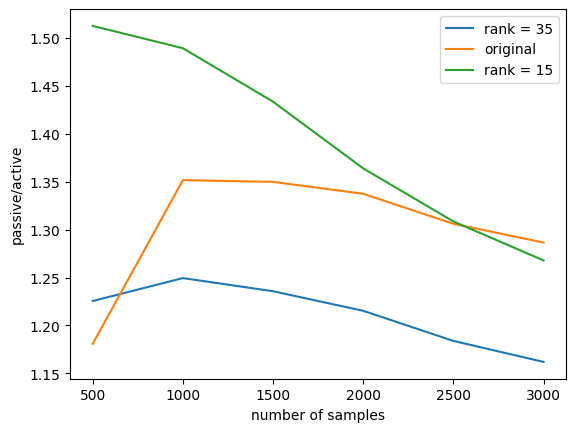

In [708]:
passive35 = [15.524240466303851, 11.98642833431055, 10.176737983808149, 9.046688076318794, 8.278559507129708, 7.69644280762668]
active35 = [12.667659745963482, 9.59344031270737, 8.23555913860616, 7.444134810763844, 6.992883827971606, 6.6238777339369355]

passivefull = [19.912809494904366, 15.157800230540834, 12.601691164202437, 10.98119312696047, 9.89655488854311, 9.072788913160455]
activefull = [16.863801623918214, 11.21391689955902, 9.335591869184354, 8.21045173427736, 7.5771768330263285, 7.052071773568656]

passive15 = [13.525701703394711, 9.990232412297098, 8.194411820127264, 7.081048369219398, 6.3842927393333335, 5.881558063630094]
active15 = [8.941594391912854, 6.707522616817211, 5.716001999013976, 5.191681297708799, 4.878859698995575, 4.6390197008933605]

plt.plot(data['passive']['time'],np.divide(passive35,active35),label='rank = 35')
plt.plot(data['passive']['time'],np.divide(passivefull,activefull),label='original')
plt.plot(data['passive']['time'],np.divide(passive15,active15),label='rank = 15')
plt.xlabel('number of samples')
plt.ylabel('passive/active')
plt.legend()
plt.show()

# Input Design

0 69742.34375 tensor(309, device='cuda:0')
200 10314.6328125 tensor(245, device='cuda:0')
400 10116.1982421875 tensor(251, device='cuda:0')
600 10039.1279296875 tensor(244, device='cuda:0')
800 10010.2060546875 tensor(246, device='cuda:0')
1000 9991.95703125 tensor(257, device='cuda:0')
1200 9992.0478515625 tensor(244, device='cuda:0')
1400 9982.703125 tensor(257, device='cuda:0')
1600 9991.1328125 tensor(249, device='cuda:0')
1800 9992.9921875 tensor(255, device='cuda:0')
2000 9995.234375 tensor(257, device='cuda:0')
2200 10000.201171875 tensor(253, device='cuda:0')
2400 10001.11328125 tensor(253, device='cuda:0')
2600 10005.296875 tensor(251, device='cuda:0')
2800 10010.658203125 tensor(251, device='cuda:0')
2999 10008.8427734375 tensor(259, device='cuda:0')


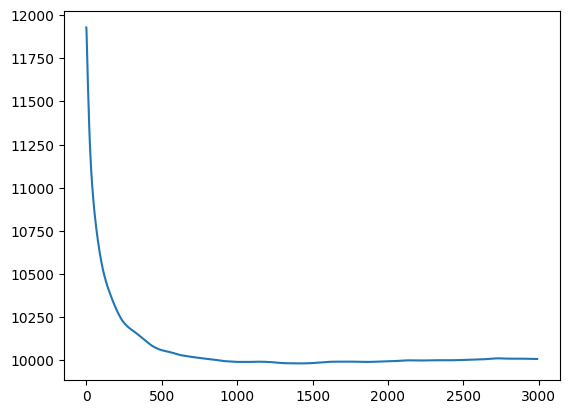

In [583]:
import importlib
import input_design
importlib.reload(est)

d = 663
u_batch_orig, u_random_orig = input_design.design_inputs_V(transfer_gt, verbose=True, num_batches=250, n_iters=3000)

(1000,)
16.231
0.015435736


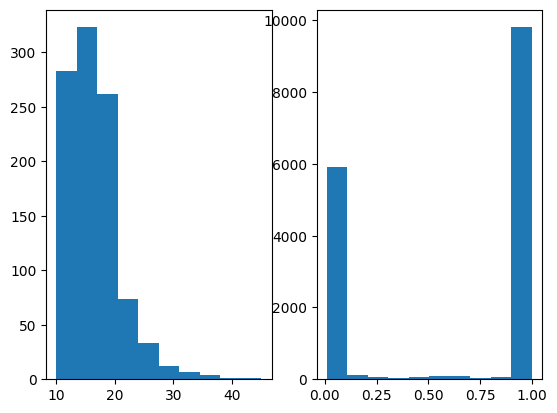

In [152]:
#u_batch_np = u_batch.cpu().clone().detach().numpy()
#u_random_np = u_random.cpu().clone().detach().numpy()
# u_nnz = u_batch_np > 0
# plt.hist(u_batch_np[u_nnz].flatten())
# plt.plot()

nnz_column = np.sum(u_batch_np > 0.01, axis=0)
print(nnz_column.shape)
plt.subplot(1,2,1)
plt.hist(nnz_column)
plt.plot()
plt.subplot(1,2,2)
plt.hist(u_batch_np[u_batch_np > 0.01].flatten())

print(np.mean(nnz_column))
print(np.mean(u_batch_np.flatten()))
#print(nnz_column)

# plt.hist(np.linalg.norm(u_batch_np, axis=1))
# plt.plot()

#print(np.max(u_batch_np))

# Fisher Design

0 1008944.1875 990183.6875 331.636 167.35596875
5 2474853.0 8679.3681640625 330.556 328.4275625
10 2452599.75 8519.1572265625 327.85333 325.03325
15 2414339.75 8536.3359375 324.51065 319.49272916666666
20 2358971.75 8655.6083984375 320.36398 311.5819375
25 2283514.5 8901.0390625 314.76932 300.92439583333334
30 2185750.5 9096.1220703125 308.16666 287.2200208333333
35 2063754.75 9530.734375 300.676 270.252125
40 1920061.75 10195.5673828125 291.904 250.54158333333334
45 1762706.5 10956.4921875 282.12933 229.24214583333332
50 1601234.125 12047.1748046875 271.268 207.58379166666666
55 1443089.125 13359.095703125 259.60532 186.4809375
60 1292220.875 14697.71484375 247.45467 166.42425
65 1151280.75 16304.3095703125 234.58133 147.70455208333334
70 1021601.9375 17997.650390625 221.57866 130.49702083333332
75 903549.0 19763.001953125 208.46133 114.82783333333333
80 797357.1875 21726.408203125 195.42133 100.71619791666667
85 702579.125 23622.09375 182.80533 88.12357291666666
90 618654.3125 25519.

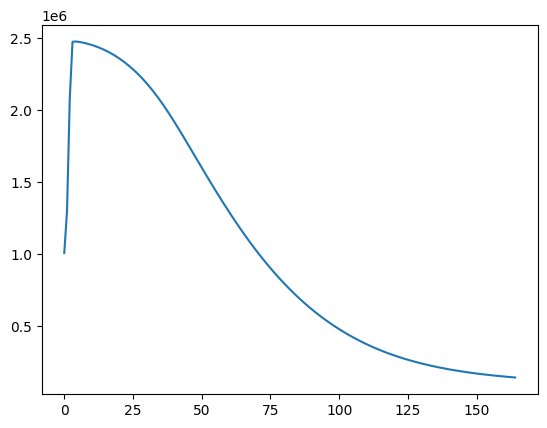

In [88]:
import importlib
import input_design
importlib.reload(est)
    
T = 5100
T_gt = torch.tensor(transfer_gt).float()
u_batch_np, u_random_np = input_design.design_inputs_fisher(T_gt,n_iters=1500,num_batches=750,num_random=1)

0 15103.38671875 310.83502 30.0
1 2722.65234375 278.93402 30.0
2 2040.330078125 263.95102 30.0
3 1788.460693359375 254.462 29.999998046875
4 1675.0504150390625 246.67502 30.0
5 1622.0540771484375 239.36801 30.000001953125
6 1594.684326171875 232.42401 30.00000390625
7 1566.1998291015625 225.25902 29.999998046875
8 1511.67041015625 218.09702 30.00000390625
9 1420.1527099609375 210.51201 29.999998046875
10 1304.1358642578125 202.09901 29.999998046875
11 1183.7415771484375 193.05602 29.999998046875
12 1072.490966796875 183.75401 29.99999609375
13 974.898681640625 174.296 30.000005859375
14 890.8803100585938 165.39001 29.999998046875
15 819.4371337890625 156.822 29.99999609375
16 759.6107177734375 148.826 30.000009765625
17 710.78759765625 141.24701 30.0
18 671.2101440429688 134.291 30.000001953125
19 638.7184448242188 127.81601 29.999998046875
20 611.6444091796875 121.864006 29.999994140625
21 588.882080078125 116.31901 29.999998046875
22 569.593505859375 111.30501 30.000005859375
23 553.

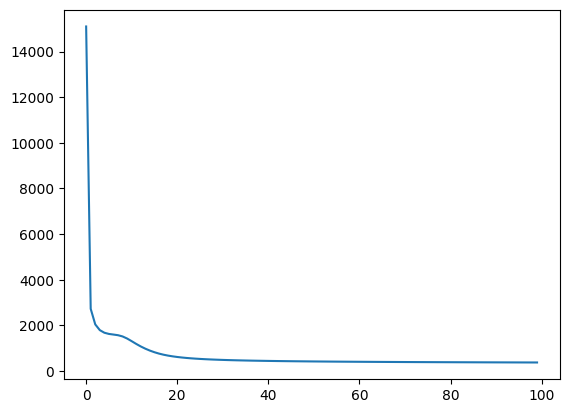

In [583]:
import importlib
import input_design
importlib.reload(est)

T_gt = torch.tensor(transfer_gt_lr).float()
u_batch_np, u_random_np = input_design.design_inputs_constrained(T_gt,
                                                                 n_iters=100,
                                                                 l1_constraint=30,
                                                                 k=50,
                                                                 num_batches=1000,
                                                                 num_random=None,
                                                                 verbose=True,
                                                                 V_design=True)

(663, 1000)


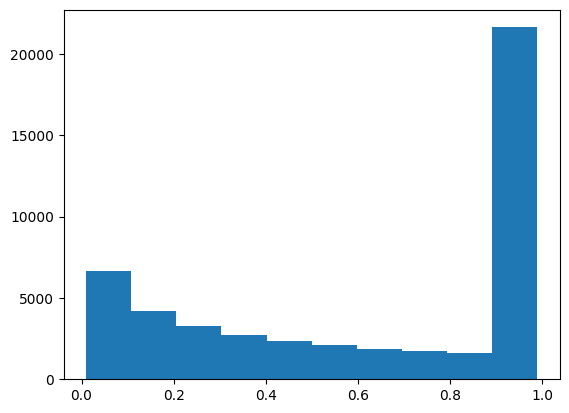

In [315]:
#u_batch_np = np.concatenate((u_batch_np1,u_batch_np2), axis=1)
l1_norms = np.linalg.norm(u_batch_np, 1, axis=0)
print(u_batch_np.shape)
x = u_batch_np.flatten()
plt.hist(x[x > 0.01])
plt.show()
#print(la.norm(u_batch_np1 - u_batch_np2) / la.norm(u_batch_np1))

# Decomposing matrix into diag + low-rank

0 1759071.0
10 74650.890625
20 15017.0302734375
30 6702.912109375
40 2479.01220703125
50 917.6103515625
60 369.34185791015625
70 156.90220642089844
80 76.11522674560547
90 44.27838897705078
100 30.55440902709961
110 23.916948318481445
120 20.267160415649414
130 18.023685455322266
140 16.536165237426758
150 15.474875450134277
160 14.680599212646484
170 14.066238403320312
180 13.57943344116211
190 13.1863431930542
200 12.864151000976562
210 12.596794128417969
220 12.372608184814453
230 12.182893753051758
240 12.021038055419922
250 11.88192367553711
260 11.7615327835083
270 11.656675338745117
280 11.564779281616211
290 11.4837646484375
300 11.41191291809082
310 11.34781265258789
320 11.290279388427734
330 11.238313674926758
340 11.191064834594727
350 11.147804260253906
360 11.107892990112305
370 11.070775985717773
380 11.035954475402832
390 11.002979278564453
400 10.971443176269531
410 10.940961837768555
420 10.911173820495605
430 10.881736755371094
440 10.852315902709961
450 10.822574615

3670 5.111124038696289
3680 5.095826148986816
3690 5.080520153045654
3700 5.065481662750244
3710 5.0498762130737305
3720 5.0346360206604
3730 5.019264221191406
3740 5.003812313079834
3750 4.988412857055664
3760 4.973038196563721
3770 4.957675457000732
3780 4.942323207855225
3790 4.927011013031006
3800 4.911674976348877
3810 4.8963541984558105
3820 4.881081581115723
3830 4.865970611572266
3840 4.850650310516357
3850 4.8354034423828125
3860 4.820247173309326
3870 4.80513334274292
3880 4.790058135986328
3890 4.775030136108398
3900 4.76005220413208
3910 4.745401382446289
3920 4.730250358581543
3930 4.715439319610596
3940 4.700685501098633
3950 4.685985088348389
3960 4.67160177230835
3970 4.656833648681641
3980 4.6422882080078125
3990 4.627840995788574
4000 4.6136932373046875
4010 4.599196434020996
4020 4.58530855178833
4030 4.570883750915527
4040 4.5567626953125
4050 4.543068885803223
4060 4.528849124908447
4070 4.514981269836426
4080 4.501198768615723
4090 4.487588405609131
4100 4.4740610

7240 0.9885232448577881
7250 0.9848136901855469
7260 0.9821447134017944
7270 0.9797497987747192
7280 0.9781112670898438
7290 0.974928081035614
7300 0.9731188416481018
7310 0.9721975326538086
7320 0.9701490998268127
7330 0.9675548076629639
7340 0.965827465057373
7350 0.9646916389465332
7360 0.962581992149353
7370 0.9609698057174683
7380 0.9598905444145203
7390 0.959638774394989
7400 0.9586251974105835
7410 0.9564042091369629
7420 0.9552052021026611
7430 0.9535802602767944
7440 0.9530448913574219
7450 0.9516785740852356
7460 0.9515436291694641
7470 0.9512060880661011
7480 0.9494403600692749
7490 0.9500155448913574
7500 0.9483333826065063
7510 0.9479097127914429
7520 0.9471244215965271
7530 0.9476398229598999
7540 0.9466062784194946
7550 0.946899950504303
7560 0.9470617175102234
7570 0.9457558989524841
7580 0.9455453157424927
7590 0.9448585510253906
7600 0.9437466263771057
7610 0.9439839124679565
7620 0.9445634484291077
7630 0.9441341161727905
7640 0.9438037872314453
7650 0.94500756263732

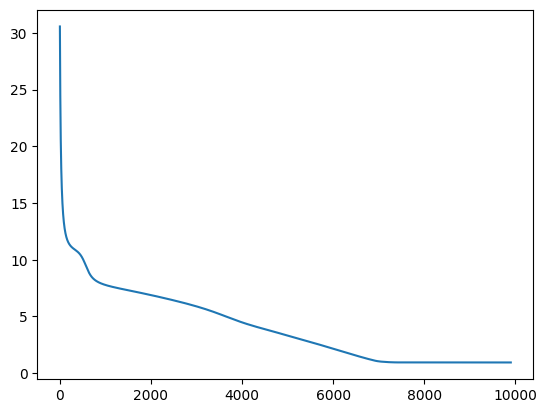

[0.9433503150939941, 0.9429116249084473, 0.943088173866272, 0.9426947832107544, 0.9427528381347656]


In [7]:
# d = 100
# U = torch.randn(d,5)
# V = torch.randn(d,5)
# D_gt = torch.diag(torch.randn(d))
# A_lr = U @ V.T
# A_gt = D_gt + A_lr
A_gt = torch.tensor(transfer_gt).float()
r = 7
d = 502

D_opt = torch.randn(d, requires_grad=True)
U_opt = torch.randn(d,r, requires_grad=True)
V_opt = torch.randn(d,r, requires_grad=True)
optimizer = optim.Adam([D_opt,U_opt,V_opt], lr=0.1)

loss_vals = []
reg = 0.01
for t in range(10000):
    optimizer.zero_grad()
    loss = torch.linalg.norm(A_gt - torch.diag(D_opt) - U_opt @ V_opt.T, 'fro')**2
    loss += reg * torch.linalg.norm(U_opt, 'fro')**2 + reg * torch.linalg.norm(V_opt, 'fro')**2
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
    if np.mod(t,10) == 0:
        #print(t,loss.item(),torch.linalg.norm(D_gt - torch.diag(D_opt),'fro'),torch.linalg.norm(A_lr - U_opt @ V_opt.T, 'fro'))
        print(t,loss.item())
plt.plot(loss_vals[100:])
plt.show()
print(loss_vals[-5:])
transfer_gt_lr = U_opt @ V_opt.T
transfer_gt_lr = transfer_gt_lr.detach().cpu().numpy()

In [8]:
print(torch.linalg.norm(A_gt - torch.diag(D_opt) - U_opt @ V_opt.T, 'fro') / torch.linalg.norm(A_gt, 'fro'))
transfer_gt_lr = U_opt @ V_opt.T
transfer_gt_lr = transfer_gt_lr.detach()
_,S,_ = torch.linalg.svd(transfer_gt_lr)
print(S.sum())

tensor(0.0750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0331, device='cuda:0')


In [691]:
print(la.norm(transfer_gt))

6.501480251766229e+18


# Individual input optimization

0 -3.885655530666554e-07 164.0 14.999987
10 -1.0536034096730873e-05 94.0 14.999997
20 -1.7733733329805546e-05 88.0 14.999995
30 -1.9073486328125e-05 58.0 14.999988
40 -1.9759367205551825e-05 51.0 14.99999
50 -3.496898352750577e-05 28.0 14.999998
60 -6.373313226504251e-05 16.0 15.0
70 -6.768557068426162e-05 16.0 14.999997
80 -6.625686364714056e-05 20.0 15.000001
90 -4.860475382884033e-05 20.0 14.999997
100 -2.6670615625334904e-05 12.0 14.999999
110 -2.5904562789946795e-05 9.0 14.999999
120 -2.3487749785999767e-05 13.0 15.000002
130 -1.8896362234954722e-05 13.0 14.999999
140 -2.286126618855633e-05 13.0 15.000004
150 -9.195801249006763e-05 10.0 14.999998
160 -0.00022382983297575265 9.0 14.999998
170 -0.0002824865223374218 5.0 15.0
180 -0.0003022525052074343 4.0 15.000002
190 -0.0003178524784743786 2.0 15.0


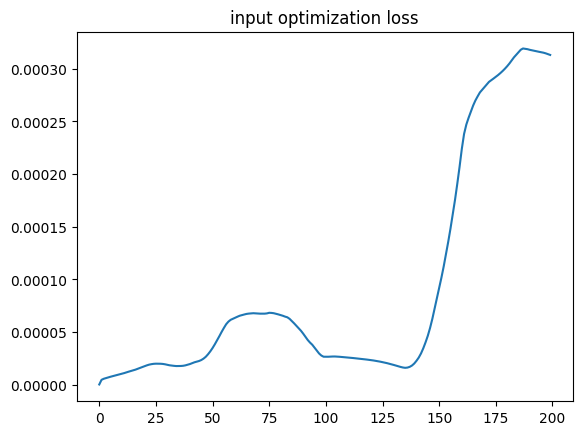

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [18]:
def l1_proj_single(u_batch, max_on=15):
    if torch.linalg.norm(u_batch, 1) <= max_on:
        return u_batch
    d = u_batch.shape[0]
    u_proj = torch.zeros_like(u_batch)
    sort_idx = torch.argsort(u_batch, descending=True)
    running_sum = 0
    max_j = 0
    max_sum = 0
    for j in range(d):
        uj = u_batch[sort_idx[j]]
        running_sum += uj
        if uj - (running_sum - max_on) / (j+1) > 0:
            max_j = j + 1
            max_sum = running_sum.clone()
    theta = (max_sum - max_on) / max_j
    u_proj = u_batch - theta
    u_proj.clamp_(min=0)
    u_batch.data = u_proj
    return u_batch

def single_input_opt(transfer_est, 
        input_cov,
        verbose=True, 
        n_iters=1000, 
        l1_constraint=15, 
        k=50):
    transfer_est = torch.tensor(transfer_est).float()
    d = transfer_est.shape[0]
    u_batch = torch.tensor(0.1*torch.randn(d), requires_grad=True, dtype=torch.float32)
    with torch.no_grad():
        u_batch = l1_proj_single(u_batch, max_on=l1_constraint)
    optimizer = optim.Adam([u_batch], lr=0.5)

    _,_,V_true = torch.linalg.svd(transfer_est)
    V_true = torch.tensor(V_true[0:k,:], dtype=torch.float32)
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    
    input_cov = torch.tensor(input_cov).float()
    cov0 = V_true @ input_cov @ V_true.T + 0.000001 * torch.eye(k)
    cov0_inv = torch.linalg.inv(cov0)
    cov0_inv_sq = cov0_inv @ cov0_inv
    
    for n in range(n_iters):
        optimizer.zero_grad()
        loss = -u_batch.T @ V_true.T @ cov0_inv_sq @ V_true @ u_batch
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        with torch.no_grad():
            u_batch = l1_proj_single(u_batch, max_on=l1_constraint)
        if np.mod(n,10) == 0 and verbose:
            nnz_column = torch.sum(u_batch > 0.01)
            print(n,loss_val,torch.mean(nnz_column.float()).cpu().numpy(),la.norm(u_batch.clone().detach().cpu().flatten().numpy(), 1))
        loss_vals.append(-loss_val)
        if loss_val < min_loss:
            min_loss = loss_val
            min_inputs = u_batch.clone()
    #if verbose:
    plt.plot(loss_vals)
    plt.title("input optimization loss")
    plt.show()

    u_batch_np = min_inputs.cpu().clone().detach().numpy()
    return u_batch_np

T = transfer_gt.copy()
input_cov = np.random.randn(663,663)
input_cov = input_cov @ input_cov.T
x = single_input_opt(T,input_cov,n_iters=200)

In [117]:
A = np.random.randn(20,20)
U,S,V = la.svd(A)
V2 = V[0:10,:]

X = np.zeros((10,10))
for t in range(100000):
    u_idx = np.random.choice(range(20), size=4, replace=False)
    u = np.zeros(20)
    u[u_idx] = 1.0
    X += V2 @ np.outer(u,u) @ V2.T / 100000
print(X)

[[ 2.15731631e-01 -4.85366925e-03 -8.43842354e-02 -1.94260727e-02
  -8.59254014e-03 -1.59593285e-02  3.09963600e-03  3.41391399e-02
   2.25941121e-02 -3.11868905e-02]
 [-4.85366925e-03  1.69795135e-01  1.11746052e-02  2.69595253e-03
   6.17616037e-04  2.20653412e-03 -2.27767573e-04 -4.10608984e-03
  -3.85700108e-03  5.29580094e-03]
 [-8.43842354e-02  1.11746052e-02  3.17689970e-01  3.37644521e-02
   1.50087983e-02  2.83930692e-02 -6.13502280e-03 -6.14833984e-02
  -4.18168715e-02  5.67256774e-02]
 [-1.94260727e-02  2.69595253e-03  3.37644521e-02  1.76814624e-01
   2.58536373e-03  6.06350481e-03 -1.62720915e-03 -1.44652951e-02
  -9.90994983e-03  1.29407366e-02]
 [-8.59254014e-03  6.17616037e-04  1.50087983e-02  2.58536373e-03
   1.69025207e-01  3.35544360e-03 -9.24642660e-05 -6.52777834e-03
  -3.53719032e-03  6.12049868e-03]
 [-1.59593285e-02  2.20653412e-03  2.83930692e-02  6.06350481e-03
   3.35544360e-03  1.74114485e-01 -1.34853871e-03 -1.18394328e-02
  -6.85418318e-03  1.06688659e-02

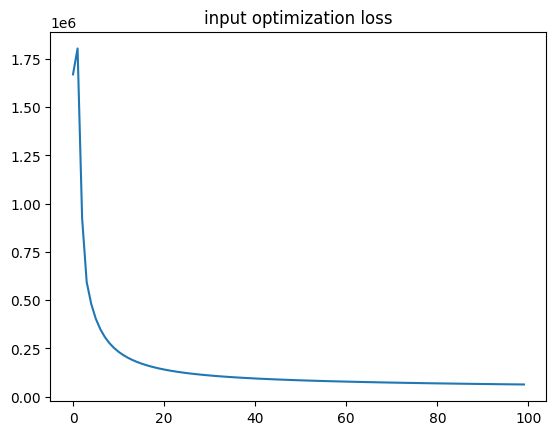

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.01945107,
         0.        ],
        [0.00554188, 0.        , 0.        , ..., 0.06976137, 0.        ,
         0.4899361 ],
        [0.31445813, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.43733805],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.18821771, ..., 0.        , 0.17501618,
         0.0145536 ]], dtype=float32),
 None)

In [122]:
input_design.design_inputs_constrained(transfer_gt,
                                         n_iters=100,
                                         l1_constraint=30,
                                         k=663,
                                         num_batches=750,
                                         verbose=False,
                                         V_design=True,
                                         cov0=None)